In [74]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from tabulate import tabulate

# **Wind Farm #1**

In [75]:
DATA_PATH = 'Datasets'

df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 1 (Nominal capacity-99MW).xlsx'), 
)

pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [76]:
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']

In [77]:
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [78]:
df_wf1.describe()

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,5.711011,222.829748,6.039255,220.633957,6.168763,221.868203,6.375876,216.986224,8.543324,889.527469,37.581143,23.426896
std,3.119512,73.705902,3.700131,79.846922,3.874708,83.092270,3.907965,85.404564,13.368410,2.439019,18.896256,24.130181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.131000,858.400000,1.502000,0.000000
25%,3.538000,209.431500,3.302000,192.871000,3.194000,169.800000,3.300000,144.067000,-3.271000,889.550000,22.355000,1.572839
50%,5.389000,235.987000,5.783000,245.442000,5.811000,251.833000,5.879500,248.825000,9.823000,889.742000,34.401500,14.957783
75%,7.217250,275.287000,8.091000,277.580250,8.384000,281.433000,8.604000,279.304250,19.756000,889.925000,51.584000,40.215230
max,25.465000,358.987000,29.187000,359.087000,29.678000,358.933000,30.247000,358.500000,36.130000,918.192000,93.120000,98.094440


In [79]:
df_wf1[df_wf1['Power(MW)'] == 0.0]

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
39247,2020-02-13 19:45:00,3.378,125.700,4.118,111.548,4.456,114.367,4.631,110.267,-1.859,889.567,24.475,0.0
39248,2020-02-13 20:00:00,3.343,128.193,4.602,109.619,4.861,111.433,5.040,105.733,-2.201,890.200,25.381,0.0
39249,2020-02-13 20:15:00,3.448,142.987,4.513,115.724,4.681,116.833,4.736,110.300,-2.814,890.283,25.963,0.0
39250,2020-02-13 20:30:00,3.503,147.780,4.755,117.541,4.727,119.900,4.728,114.000,-2.753,889.583,25.968,0.0
39251,2020-02-13 20:45:00,3.656,139.320,4.862,111.267,5.121,112.900,5.258,108.533,-3.267,890.100,26.437,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,2020-08-22 21:15:00,6.288,266.327,7.827,264.050,8.048,268.900,8.369,266.983,22.202,889.400,23.480,0.0
57590,2020-08-22 21:30:00,6.451,260.760,7.705,262.396,8.150,267.700,8.494,264.900,21.460,889.717,24.067,0.0
57591,2020-08-22 21:45:00,5.180,258.653,6.334,259.231,6.924,265.633,7.119,260.400,21.502,889.567,24.744,0.0
57592,2020-08-22 22:00:00,5.211,241.840,6.157,245.209,6.550,253.367,6.766,248.783,21.014,889.550,25.536,0.0


In [80]:
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       70176 non-null  object 
 1   WS_10      70176 non-null  float64
 2   WD_10      70176 non-null  float64
 3   WS_30      70176 non-null  float64
 4   WD_30      70176 non-null  float64
 5   WS_50      70176 non-null  float64
 6   WD_50      70176 non-null  float64
 7   WS_cen     70176 non-null  float64
 8   WD_cen     70176 non-null  float64
 9   Air_T      70176 non-null  float64
 10  Air_P      70176 non-null  float64
 11  Air_H      70176 non-null  float64
 12  Power(MW)  70176 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


In [81]:
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [82]:
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Air_H        0.0
Power(MW)    0.0
dtype: float64

In [83]:
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [84]:
df_wf1_filtered = df_wf1[df_wf1['Power(MW)'] != 0.0]

## **Pairplots**

In [85]:
#sns.pairplot(df_wf1, hue=None, size=2.5)

## **Correlation matrix**

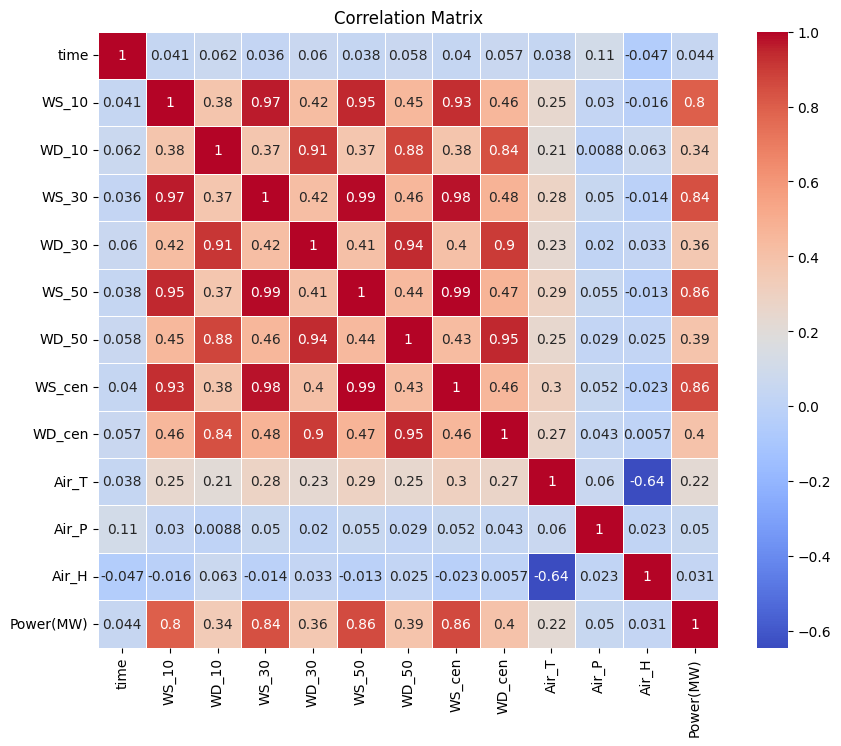

In [86]:
correlation_matrix = df_wf1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [87]:
pearsonr(df_wf1['WS_10'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7998595044473422, pvalue=0.0)

In [88]:
pearsonr(df_wf1['WS_30'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8399594587604483, pvalue=0.0)

In [89]:
pearsonr(df_wf1['WS_50'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8563136119964403, pvalue=0.0)

In [90]:
pearsonr(df_wf1['WS_cen'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8617302465680093, pvalue=0.0)

With respect to the target variable [Power (MW)], the 4 below features have high correlations on top of very significant pvalues:
- 0.8 with Wind speed at height of 10 meters (m/s)
- 0.84 with Wind speed at height of 30 meters (m/s)
- 0.86 with Wind speed at height of 50 meters (m/s)
- 0.86 with Wind speed - at the height of wheel hub (m/s)

In [91]:
df_wf1.set_index('time', inplace=True)

In [92]:
df_wf1

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
time,,,,,,,,,,,,
2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931


## **Preparing training and testing data**

In [93]:
#df_wf1_train, df_wf1_test = train_test_split(df_wf1, train_size = 0.7, test_size = 0.3, shuffle=False)
df_wf1_train, df_wf1_test = train_test_split(df_wf1_filtered, train_size = 0.7, test_size = 0.3, shuffle=False)

In [94]:
y_train = df_wf1_train[['Power(MW)']]
X_train = df_wf1_train[['WS_10', 'WD_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen',	'WD_cen', 'Air_T', 'Air_P', 'Air_H']]

In [95]:
y_test = df_wf1_test[['Power(MW)']]
X_test = df_wf1_test[['WS_10', 'WD_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen',	'WD_cen', 'Air_T', 'Air_P', 'Air_H']]

## **OLS - Ordinary Least Squares**

In [96]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(estimator=lm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [97]:
rfe.support_

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [98]:
X_train.columns[rfe.support_]

Index(['WS_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen', 'WD_cen',
       'Air_T', 'Air_P', 'Air_H'],
      dtype='object')

In [99]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,WS_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H
0,2.209,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320
1,1.828,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757
2,2.193,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981
3,2.654,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821
4,2.249,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571


In [100]:
def build_model(X,y):
    X = sm.add_constant(X) #Adding the constant
    lm = sm.OLS(y,X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X
    
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [101]:
X_train_new = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                 1.534e+04
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        10:36:33   Log-Likelihood:            -1.8888e+05
No. Observations:               48979   AIC:                         3.778e+05
Df Residuals:                   48968   BIC:                         3.779e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -69.8248     16.226     -4.303      0.0

In [102]:
checkVIF(X_train_new)

,Features,VIF
0,const,98440.42
4,WS_50,350.28
2,WS_30,160.09
6,WS_cen,124.72
1,WS_10,19.68
5,WD_50,15.82
7,WD_cen,10.27
3,WD_30,8.92
8,Air_T,2.16
10,Air_H,1.90


In [103]:
X_train_new = X_train_new.drop(["WS_50"], axis = 1)
checkVIF(X_train_new)

,Features,VIF
0,const,98218.83
2,WS_30,51.48
5,WS_cen,25.19
1,WS_10,16.94
4,WD_50,15.82
6,WD_cen,10.25
3,WD_30,8.86
7,Air_T,2.14
9,Air_H,1.90
8,Air_P,1.02


In [104]:
X_train_new = X_train_new.drop(["WS_30"], axis = 1)
checkVIF(X_train_new)

,Features,VIF
0,const,97931.29
3,WD_50,15.69
5,WD_cen,10.12
2,WD_30,8.49
4,WS_cen,8.05
1,WS_10,7.79
6,Air_T,2.14
8,Air_H,1.89
7,Air_P,1.02


In [105]:
X_train_new = X_train_new.drop(["WD_50"], axis = 1)
checkVIF(X_train_new)

,Features,VIF
0,const,97917.08
3,WS_cen,8.03
1,WS_10,7.75
4,WD_cen,5.59
2,WD_30,5.33
5,Air_T,2.14
7,Air_H,1.89
6,Air_P,1.02


In [106]:
X_train_new = X_train_new.drop(["WS_cen"], axis = 1)
checkVIF(X_train_new)

,Features,VIF
0,const,97693.72
3,WD_cen,5.49
2,WD_30,5.24
4,Air_T,2.03
6,Air_H,1.85
1,WS_10,1.30
5,Air_P,1.02


In [107]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 1.500e+04
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        10:36:34   Log-Likelihood:            -1.9810e+05
No. Observations:               48979   AIC:                         3.962e+05
Df Residuals:                   48972   BIC:                         3.963e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -186.1179     19.509     -9.540      0.0

In [108]:
lm = sm.OLS(y_train,X_train_new).fit()
y_train = lm.predict(X_train_new)

In [109]:
num_vars = ['WS_10', 'WD_30', 'WD_cen', 'Air_T', 'Air_P', 'Air_H']
X_test_new = df_wf1_test[num_vars]

In [110]:
# Now let's use our model to make predictions.
X_train_new = X_train_new.drop('const',axis=1)
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [111]:
# Making predictions
predictions_ols = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

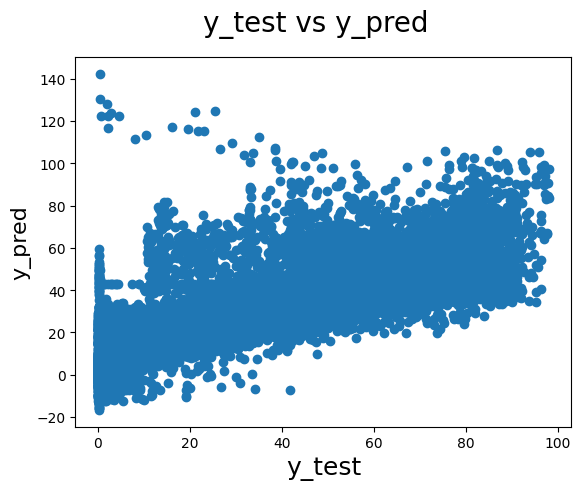

In [112]:
#EVALUATION OF THE MODEL
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,predictions_ols)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)   

In [113]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 1.500e+04
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        10:36:35   Log-Likelihood:            -1.9810e+05
No. Observations:               48979   AIC:                         3.962e+05
Df Residuals:                   48972   BIC:                         3.963e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -186.1179     19.509     -9.540      0.0

R-squared = 0.648, which is less than 0.8; typically the threshold value required to retain a model built with OLS.

In [114]:
mae_ols = mean_absolute_error(y_test, predictions_ols)
print("Mean Absolute Error (MAE):", mae_ols)

mse_ols = mean_squared_error(y_test, predictions_ols)
print("Mean Squared Error (MSE):", mse_ols)

r2_ols = r2_score(y_test, predictions_ols)
print("R-squared (R2) Score:", r2_ols)

mape_ols = mean_absolute_percentage_error(y_test, predictions_ols)
print("Mean Absolute Percentage Error (MAPE):", mape_ols)

Mean Absolute Error (MAE): 11.43001084525304
Mean Squared Error (MSE): 239.1634859209164
R-squared (R2) Score: 0.640426505485409
Mean Absolute Percentage Error (MAPE): 7.442949602627339


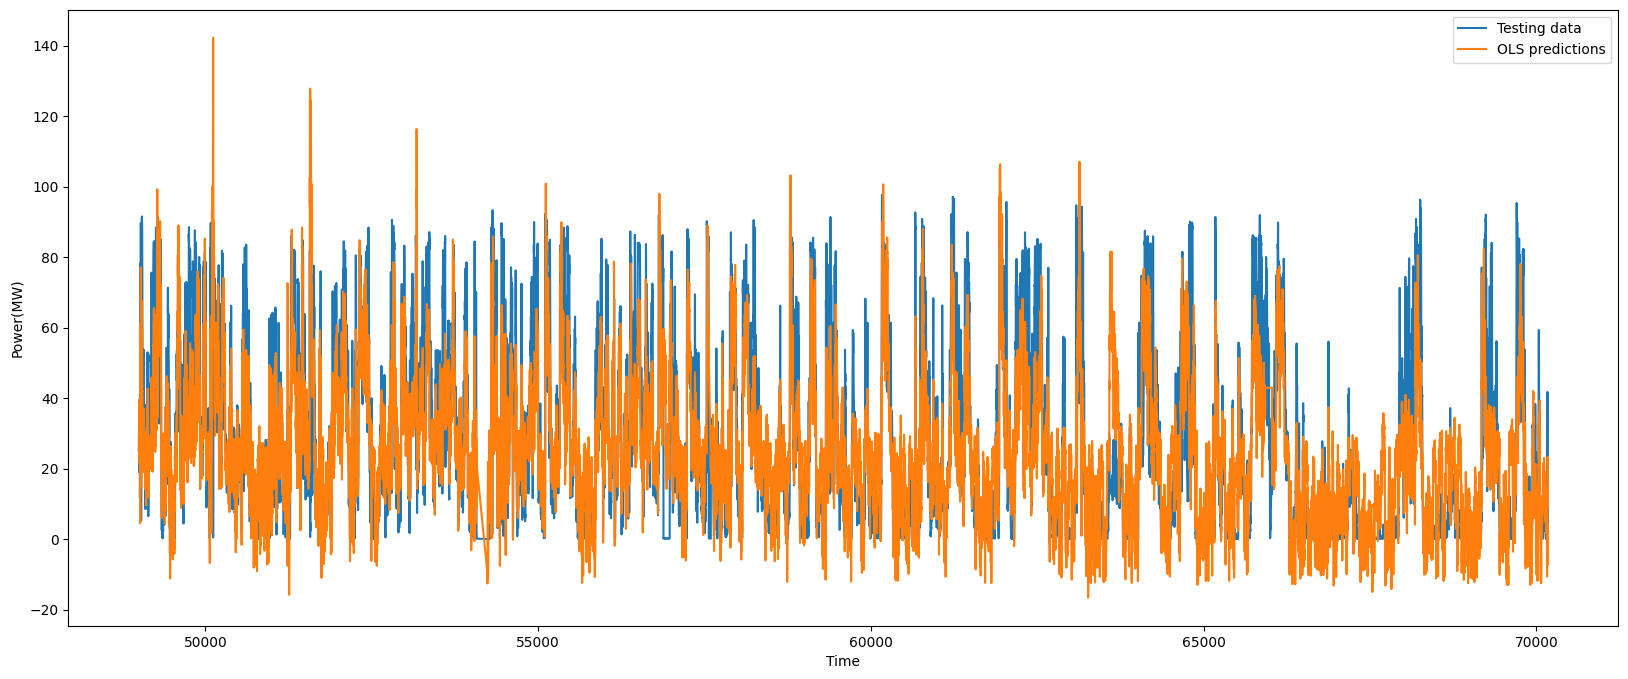

In [115]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Testing data')
plt.plot(predictions_ols, label='OLS predictions')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.legend()
plt.show()

## **LSTM - Long short-term memory**

In [116]:
X_train_lstm = X_train.values
X_test_lstm = X_test.values

X_train_lstm = X_train_lstm.reshape(X_train.shape[0], 1, X_train_lstm.shape[1])
X_test_lstm = X_test_lstm.reshape(X_test.shape[0], 1, X_test_lstm.shape[1])

model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_lstm, y_train, epochs=100, batch_size=50, verbose=1)

predictions = model.predict(X_test_lstm)
predictions_lstm = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 687.0471
Epoch 2/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 373.8221
Epoch 3/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 217.5209
Epoch 4/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 118.3834
Epoch 5/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 72.6981
Epoch 6/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 42.8839
Epoch 7/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 26.8863
Epoch 8/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.5776
Epoch 9/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.3722
Epoch 10/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.2404
Epoch 11/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.7439
Epoch 12/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2231
Epoch 13/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3205
Epoch 14/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1679
Epoch 15/100
980/980 ━━━━━━━━━━━━━━━━━━━━

In [117]:
mae_lstm = mean_absolute_error(y_test, predictions_lstm)
print("Mean Absolute Error (MAE):", mae_lstm)

mse_lstm = mean_squared_error(y_test, predictions_lstm)
print("Mean Squared Error (MSE):", mse_lstm)

r2_lstm = r2_score(y_test, predictions_lstm)
print("R-squared (R2) Score:", r2_lstm)

mape_lstm = mean_absolute_percentage_error(y_test, predictions_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

Mean Absolute Error (MAE): 11.499579323498544
Mean Squared Error (MSE): 237.69753512542422
R-squared (R2) Score: 0.6426305085266419
Mean Absolute Percentage Error (MAPE): 7.427313072147222


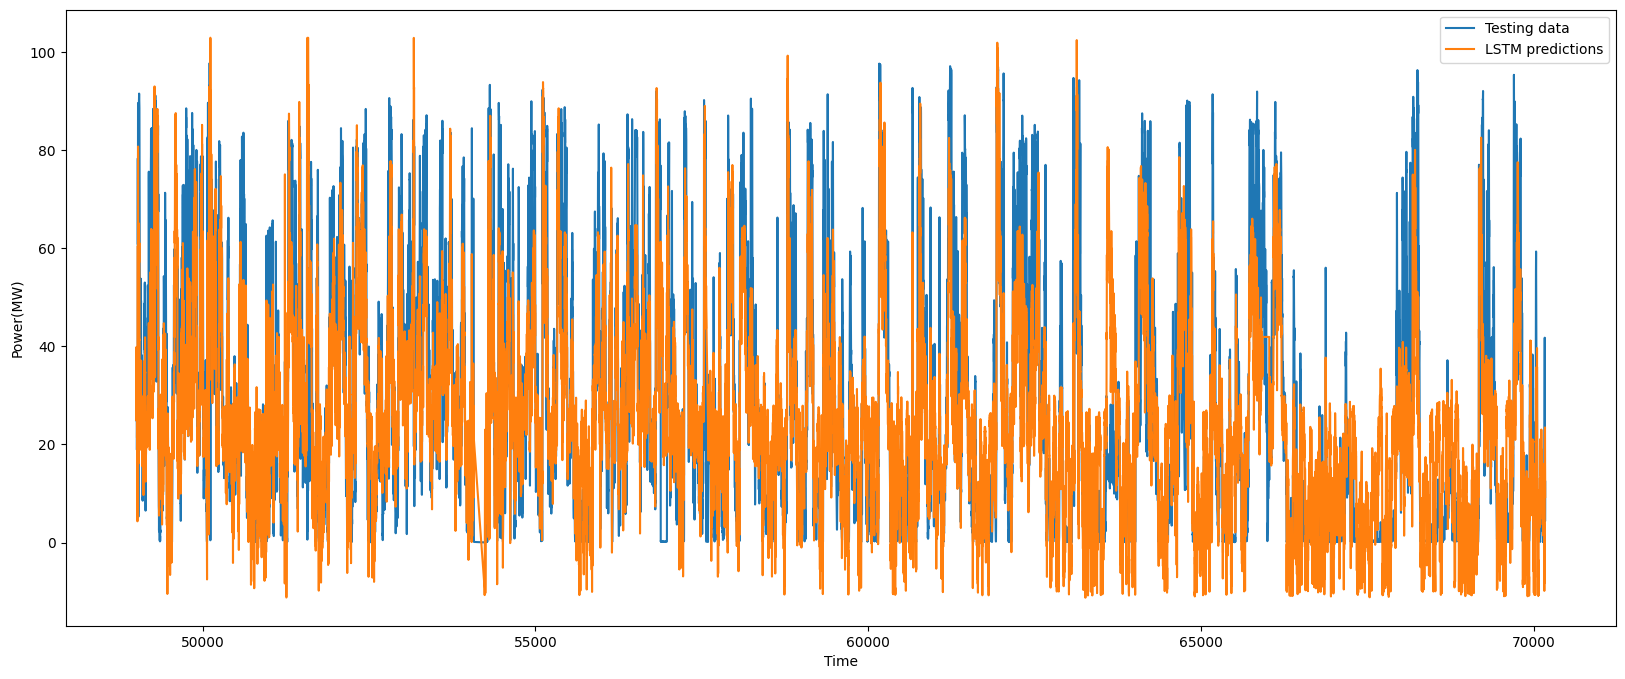

In [118]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Testing data')
plt.plot(predictions_lstm, label='LSTM predictions')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.legend()
plt.show()

## **Random Forest model**

In [253]:
randomforest_regressor = RandomForestRegressor(bootstrap=True, n_estimators=100, random_state=42)

randomforest_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=75, random_state=42)

In [254]:
predictions = randomforest_regressor.predict(X_test)
predictions_randomforest = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

In [255]:
mae_randomforest = mean_absolute_error(y_test, predictions_randomforest)
print("Mean Absolute Error (MAE):", mae_randomforest)

mse_randomforest = mean_squared_error(y_test, predictions_randomforest)
print("Mean Squared Error (MSE):", mse_randomforest)

r2_randomforest = r2_score(y_test, predictions_randomforest)
print("R-squared (R2) Score:", r2_randomforest)

mape_randomforest = mean_absolute_percentage_error(y_test, predictions_randomforest)
print("Mean Absolute Percentage Error (MAPE):", mape_randomforest)

Mean Absolute Error (MAE): 11.425501473522145
Mean Squared Error (MSE): 238.66714221528767
R-squared (R2) Score: 0.6411727399702679
Mean Absolute Percentage Error (MAPE): 7.4444885811581525


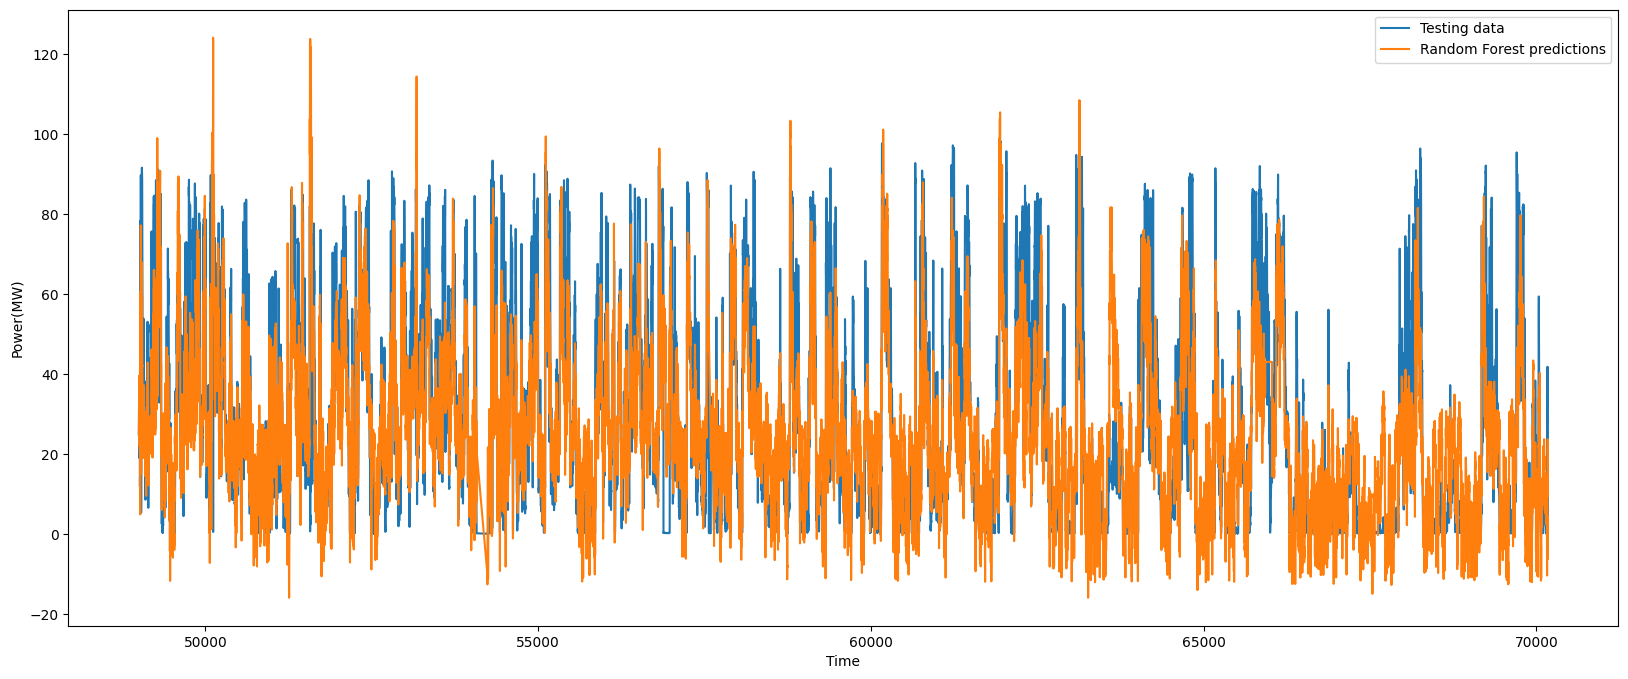

In [256]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Testing data')
plt.plot(predictions_randomforest, label='Random Forest predictions')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.legend()
plt.show()

## **XGBoost model**

In [257]:
xgboost_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.05, n_estimators=75)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [258]:
predictions = xgboost_model.predict(X_test)
predictions_xgboost = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

In [259]:
mae_xgboost = mean_absolute_error(y_test, predictions_xgboost)
print("Mean Absolute Error (MAE):", mae_xgboost)

mse_xgboost = mean_squared_error(y_test, predictions_xgboost)
print("Mean Squared Error (MSE):", mse_xgboost)

r2_xgboost = r2_score(y_test, predictions_xgboost)
print("R-squared (R2) Score:", r2_xgboost)

mape_xgboost = mean_absolute_percentage_error(y_test, predictions_xgboost)
print("Mean Absolute Percentage Error (MAPE):", mape_xgboost)

Mean Absolute Error (MAE): 11.408923224184397
Mean Squared Error (MSE): 234.64161705351773
R-squared (R2) Score: 0.647224968821593
Mean Absolute Percentage Error (MAPE): 7.182673333590379


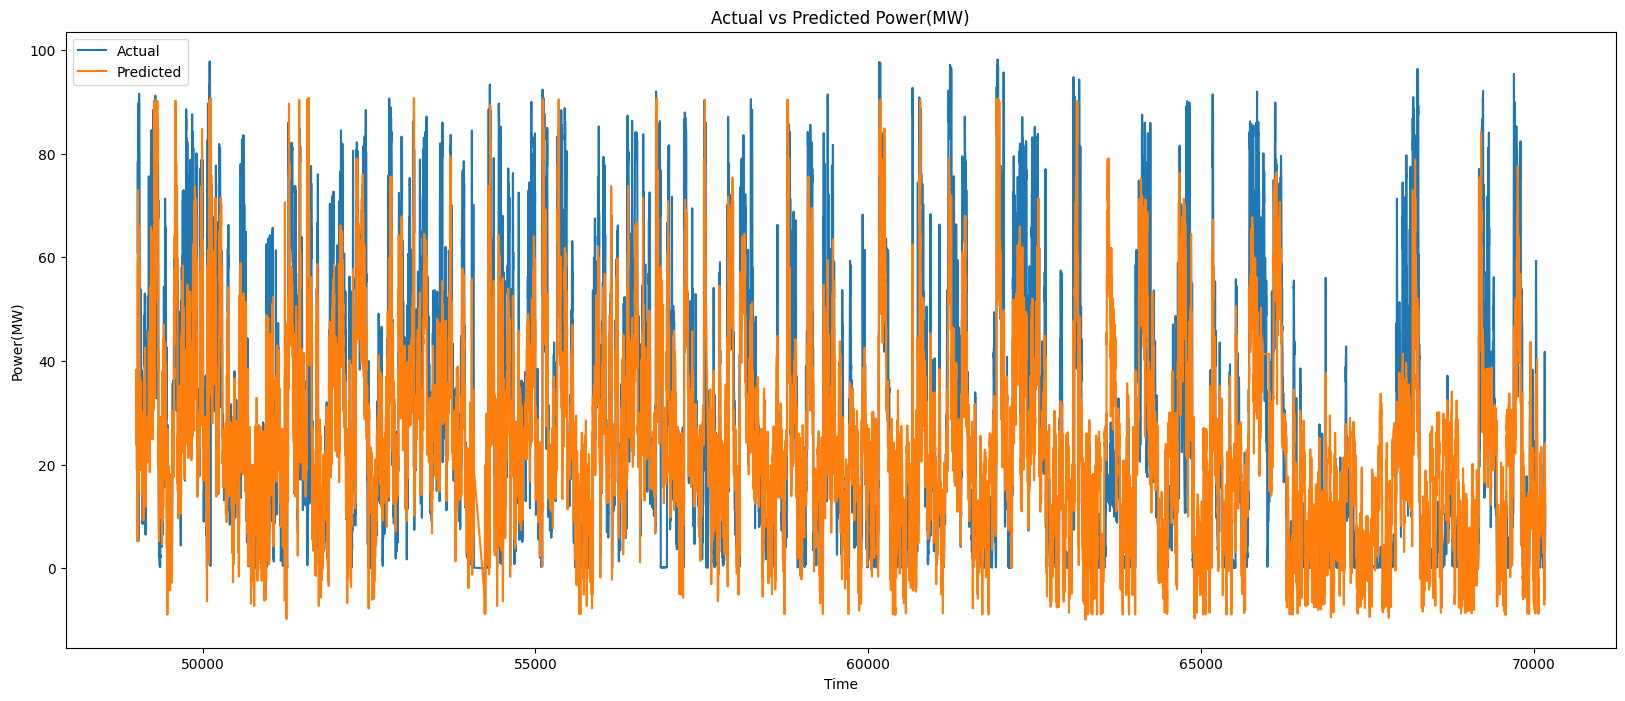

In [260]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Actual')
plt.plot(predictions_xgboost, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.title('Actual vs Predicted Power(MW)')
plt.legend()
plt.show()

## **Summary**

In [261]:
models = ["OLS ('WS_10', 'WD_30', 'WD_cen', 'Air_T', 'Air_P', 'Air_H')", "LSTM (epochs=100, batch_size=50)", "Random Forest (n_estimators=100, random_state=42)", "XGBoost (max_depth=3, learning_rate=0.1, n_estimators=150)"]
metrics = ["Mean Absolute Error (MAE)", "Mean Squarred Error (MSE)", "R-squared (R2) Score", "Mean Absolute Percentage Error (MAPE)"]
values_mae = [mae_ols, mae_lstm, mae_randomforest, mae_xgboost]
values_mse = [mse_ols, mse_lstm, mse_randomforest, mse_xgboost]
values_r2 = [r2_ols, r2_lstm, r2_randomforest, r2_xgboost]
values_mape = [mape_ols, mape_lstm, mape_randomforest, mape_xgboost]

table_data = [
    [model, mae, mse, r2, mape] for model, mae, mse, r2, mape in zip(models, values_mae, values_mse, values_r2, values_mape)
]

print(tabulate(table_data, headers=["Model", "Mean Absolute Error (MAE)", "Mean Squarred Error (MSE)", "R-squared (R2) Score", "Mean Absolute Percentage Error (MAPE)"], tablefmt="grid"))

+-------------------------------------------------------------+-----------------------------+-----------------------------+------------------------+-----------------------------------------+
| Model                                                       |   Mean Absolute Error (MAE) |   Mean Squarred Error (MSE) |   R-squared (R2) Score |   Mean Absolute Percentage Error (MAPE) |
+=============================================================+=============================+=============================+========================+=========================================+
| OLS ('WS_10', 'WD_30', 'WD_cen', 'Air_T', 'Air_P', 'Air_H') |                     11.43   |                     239.163 |               0.640427 |                                 7.44295 |
+-------------------------------------------------------------+-----------------------------+-----------------------------+------------------------+-----------------------------------------+
| LSTM (epochs=100, batch_size=50)           